- [1. Importing Functions and Packages](#1)
    - [Max Drawdown and Calmar Ratio Backtest](#1_1)
    - [Sortino Ratio Backtest](#1_2)
    - [Sharpe Ratio Backtest](#1_3)
- [2. Assembling Dataset and Backtesting Strategies](#2)
    - [2.1 Sharpe Ratio Strategy](#2_1)
    - [2.2 Calmar Ratio Strategy](#2_2)

## 1. Importing Functions and Packages <a id='1'></a>

In [145]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [64]:
def smooth(track, window_size):
    """
    Smooth out time series using a simple moving average.
    
    Parameters:
        pnl (list or Series): List or Series containing P&L data.
        window_size (int): Size of the moving average window.
        
    Returns:
        smoothed_pnl (Series): Smoothed P&L using moving average.
    """
    track_series = pd.Series(track)
    smoothed_track = track_series.rolling(window=window_size).mean()
    return smoothed_track

def kelly(decimal_odds, P, fractional):
    # shrinkage is the percent we want to shrink bets to account for uncertanity
    B = decimal_odds - 1
    Q = 1 - P
    solution = (B*P - Q) / B
    solution = solution * fractional
    return solution

def backtest(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    #df = df[df['Sportsbooks_Odds'] < 2.00]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    smooth_track = smooth(track, 10)
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], pnl, c='b')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Profit and Loss($)', size=17)
    plt.title('PnL Over Time')
    
    plt.show()  # Show the first plot
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], track, c='b')
    plt.plot(df['Date'], smooth_track, c='r')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Bankroll($)', size=17)
    plt.title('Bankroll Over Time')
    
    plt.show()
    first_day = df['Date'].min().date()
    last_day = df['Date'].max().date()
    
    print('\n')
    print(f'The position was held from {first_day} to {last_day}, traded {periods} times, and produced a return of {final_return:.4f}%.')
    print(f'The growth rate on each bet was {returns:.4f}%.')
    print(f'The final balance is ${balance}.')
    print(f'The average of returns is {avg_return:.4f}%.')
    print(f'The standard deviation of returns is {returns_std:.4f}%.')
    print('\n')
    #print(track)
    print(f'The Sharpe Ratio of the strategy is {sharpe_ratio:.4f}.')

In [129]:
def p_and_l(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    #df = df[df['Sportsbooks_Odds'] < 2.00]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    p_and_l = []
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
            p_and_l += [profit]
            
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
            p_and_l += [-bet_amount]
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    print('\n')
    print(f'The position was held for 2 months, traded {periods} times, and produced a return of {final_return:.4f}%.')
    print(f'The growth rate on each bet was {returns:.4f}%.')
    print(f'The final balance is ${balance}.')
    print(f'The average of returns is {avg_return:.4f}%.')
    print(f'The standard deviation of returns is {returns_std:.4f}%.')
    print('\n')
    #print(track)
    print(f'The Sharpe Ratio of the strategy is {sharpe_ratio:.4f}.')
    df['p_and_l'] = p_and_l
    # df['cum_pal'] = df['p_and_l'].cumsum()
    # df['cum_pal'] = df['cum_pal'] + initial
    # df['starting'] = df['cum_pal'].shift()
    # df.iloc[0, df.shape[1]-1] = 6000
    # df['return_pct'] = df['p_and_l']/df['starting']
    return df

### Max Drawdown and Calmer Ratio Backtest <a id='1_1'></a>

In [66]:
def calculate_max_drawdown(series):
    """
    Calculate drawdown from a time series of equity values.
    """
    max_dd = 0
    peak = series[0]
    drawdowns = []
    
    for val in series:
        if val > peak:
            peak = val
        dd = (peak - val) / peak
        drawdowns.append(dd)
        max_dd = max(max_dd, dd)
    
    return max_dd

def backtest_for_calmar(df, initial, shrinkage, threshold):
    """
    Backtest function to calculate the Calmar ratio.
    
    Parameters:
        df (DataFrame): DataFrame containing the backtest data.
        initial (float): Initial balance.
        shrinkage (float): Shrinkage factor for Kelly criterion.
        threshold (float): Minimum threshold for placing a bet.
        
    Returns:
        calmar_ratio (float): Calmar ratio.
    """
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index, row in df.iterrows():
        bet_amount = row['Kelly'] * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
    
    max_drawdown = calculate_max_drawdown(track)
    
    avg_return = np.mean(returns_list)
    
    if max_drawdown == 0:
        calmar_ratio = np.inf  # To handle division by zero
    else:
        calmar_ratio = avg_return / max_drawdown
    
    return calmar_ratio

### Sortino Ratio Backtest <a id='1_2'></a>

In [67]:
def backtest_for_sortino(df, initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index, row in df.iterrows():
        bet_amount = row['Kelly'] * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
    
    downside_returns = [ret for ret in returns_list if ret < 0]
    downside_deviation = np.std(downside_returns)
    
    if downside_deviation == 0:
        sortino_ratio = np.inf  # To handle division by zero
    else:
        average_return = np.mean(returns_list)
        sortino_ratio = average_return / downside_deviation
    
    return sortino_ratio

### Sharpe Ratio Backtest <a id='1_3'></a>

In [68]:
def backtest_for_sharpe(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    return sharpe_ratio

## 2. Assembling Dataset and Backtesting Strategies <a id='2'></a>

In [74]:
save_path = '/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/risk_management/'
file_name = "calibrated_adjusted_index_predictions.csv"
file_path = save_path + file_name
df = pd.read_csv(file_path, index_col=0, parse_dates=['Date'])

folder_path = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/data/odds_data/2021_01_20_onward.csv"
odds = pd.read_csv(folder_path, index_col=0)
df = df.reset_index(drop=True)
df

,Teams_x,Teams_y,Fanduel_odds_x,Draftkings_odds_x,BetMGM_odds_x,Fanduel_odds_y,Draftkings_odds_y,BetMGM_odds_y,Date,Predictions,Actual,Sportsbooks_Odds,Probabilities
0,CHO,PHI,4.85,4.90,4.75,1.20,1.20,1.20,2023-03-17,0,0,4.90,0.180000
1,BRK,SAC,1.72,1.74,1.71,2.18,2.15,2.15,2023-03-16,1,0,1.74,0.595238
2,OKC,TOR,3.05,3.15,3.20,1.40,1.39,1.36,2023-03-16,0,0,3.20,0.264901
3,POR,BOS,2.60,2.60,2.55,1.53,1.53,1.53,2023-03-17,0,0,2.60,0.395455
4,CLE,WAS,1.48,1.48,1.44,2.76,2.80,2.80,2023-03-17,1,1,1.48,0.620690
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777,MIA,CLE,2.10,2.10,2.05,1.77,1.77,1.77,2024-03-20,0,1,2.10,0.426471
1778,UTA,OKC,9.10,9.00,9.00,1.07,1.07,1.07,2024-03-20,0,0,9.10,0.000000
1779,POR,LAC,6.60,6.25,6.50,1.12,1.13,1.12,2024-03-20,0,0,6.60,0.180000
1780,SAC,TOR,1.16,1.16,1.15,5.60,5.55,5.75,2024-03-20,1,1,1.16,0.785714


In [75]:
final = df.copy()
final['Our_Odds'] = 1 / final['Probabilities']
column_order = ['Date', 'Teams_x', 'Sportsbooks_Odds','Our_Odds','Probabilities','Predictions', 'Actual']
#'Our_Odds',
final = final[column_order]
win = final[final['Predictions'] == 1]
bet = win[win['Our_Odds'] < win['Sportsbooks_Odds']]
bet['odds_diff'] = bet['Sportsbooks_Odds'] - bet['Our_Odds']
bet

/var/folders/4m/qh070ww90rqgmcw604kkdt8r0000gn/T/ipykernel_49151/1261367469.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bet['odds_diff'] = bet['Sportsbooks_Odds'] - bet['Our_Odds']


,Date,Teams_x,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual,odds_diff
1,2023-03-16,BRK,1.74,1.680000,0.595238,1,0,0.060000
7,2023-03-18,MIA,1.69,1.680000,0.595238,1,0,0.010000
8,2023-03-17,MEM,1.29,1.281250,0.780488,1,1,0.008750
10,2023-03-17,CHI,1.69,1.680000,0.595238,1,1,0.010000
18,2023-03-18,SAC,1.69,1.680000,0.595238,1,1,0.010000
...,...,...,...,...,...,...,...,...
1727,2024-03-17,MIL,1.69,1.611111,0.620690,1,1,0.078889
1741,2024-03-18,PHI,1.79,1.718750,0.581818,1,1,0.071250
1742,2024-03-17,BRK,2.05,1.840000,0.543478,1,0,0.210000
1746,2024-03-20,OKC,1.07,1.000000,1.000000,1,1,0.070000


### 2.1 Sharpe Ratio Strategy <a id='2_1'></a>

Criterion for Sharp Strategy
- Differences in our odds and sportsbook odds bigger than 0.41
- Odds threshold of 1.79

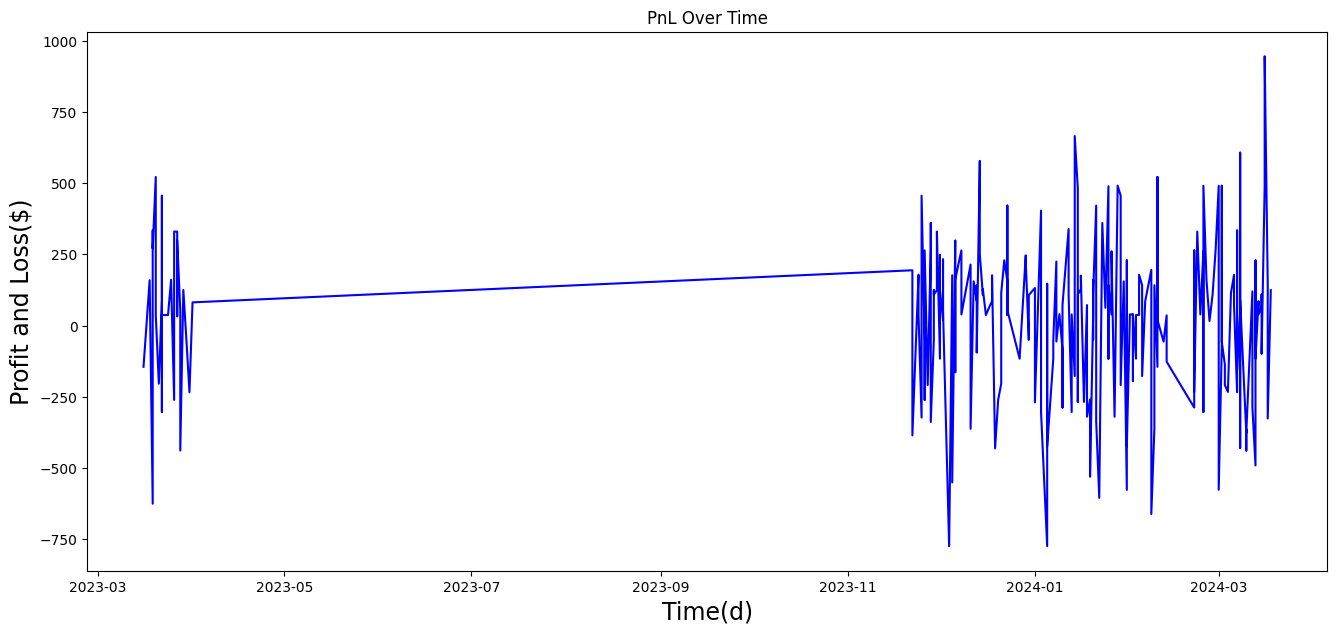

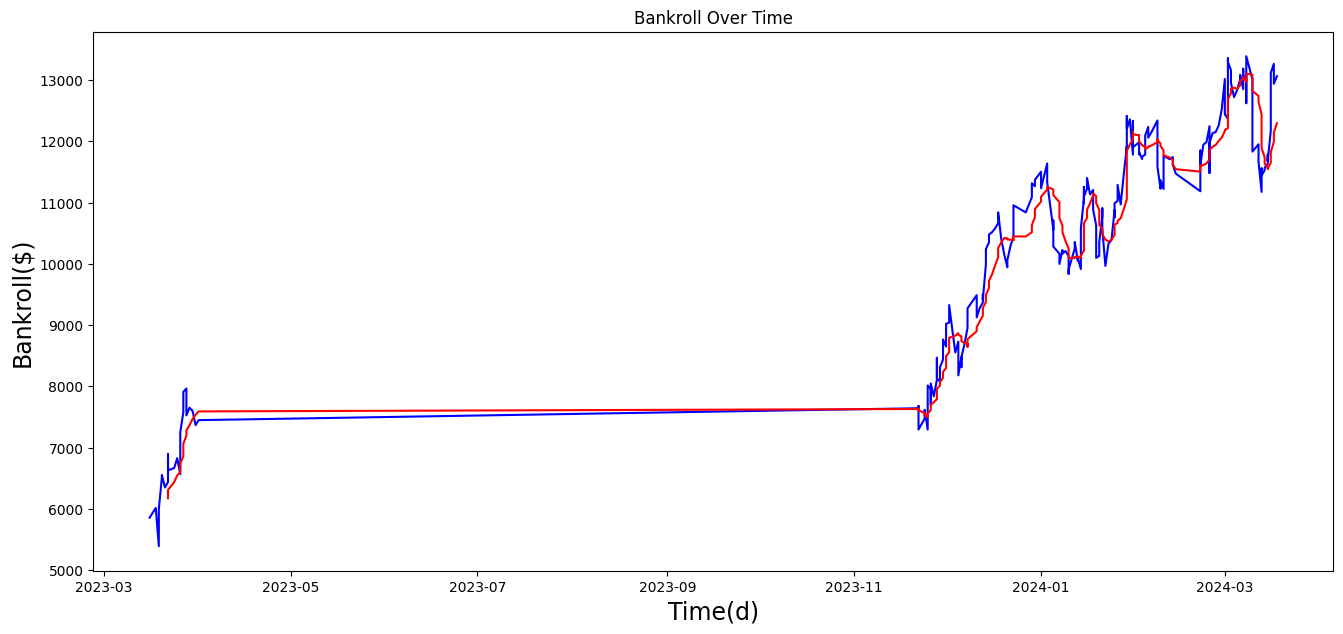



The position was held from 2023-03-16 to 2024-03-18, traded 246 times, and produced a return of 117.7238%.
The growth rate on each bet was 0.3168%.
The final balance is $13063.43.
The average of returns is 74.2937%.
The standard deviation of returns is 32.0010%.


The Sharpe Ratio of the strategy is 2.3216.


In [76]:
threshold_sharpe = 1.1
spread_sharpe = 0.01
bet_sharpe = bet[bet['odds_diff'] > spread_sharpe]
backtest(bet_sharpe, 6000, 0.5, threshold_sharpe)

### 2.2 Calmar Ratio Strategy <a id='2_2'></a>

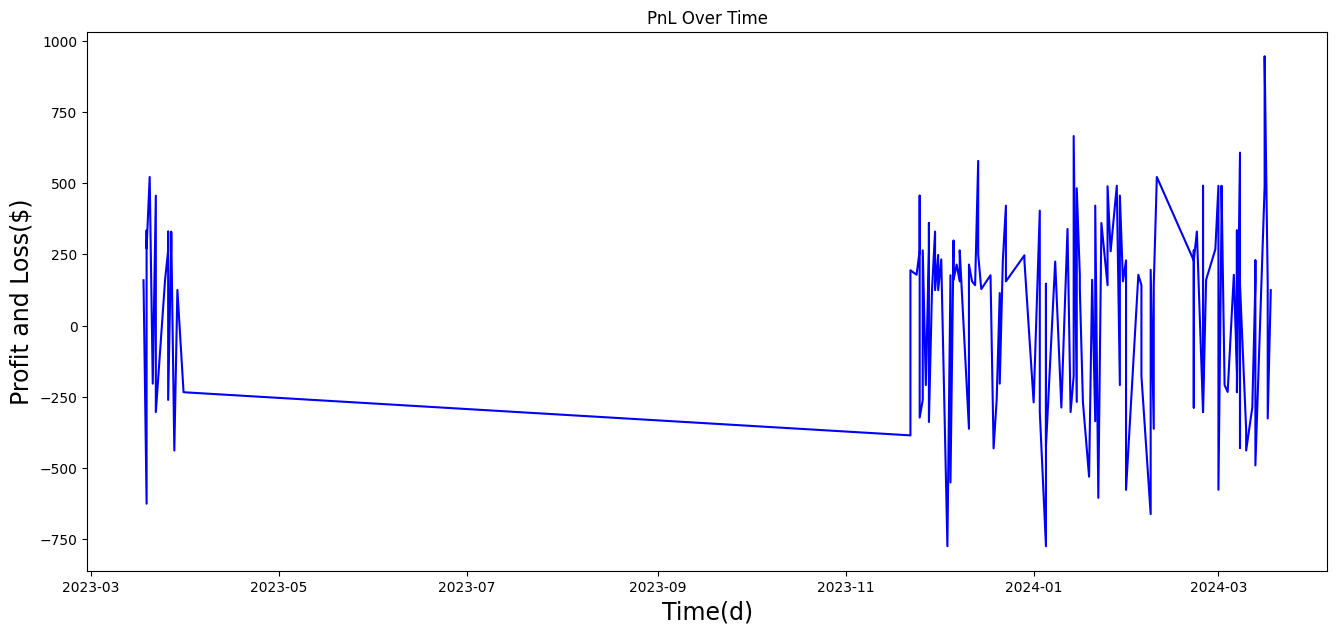

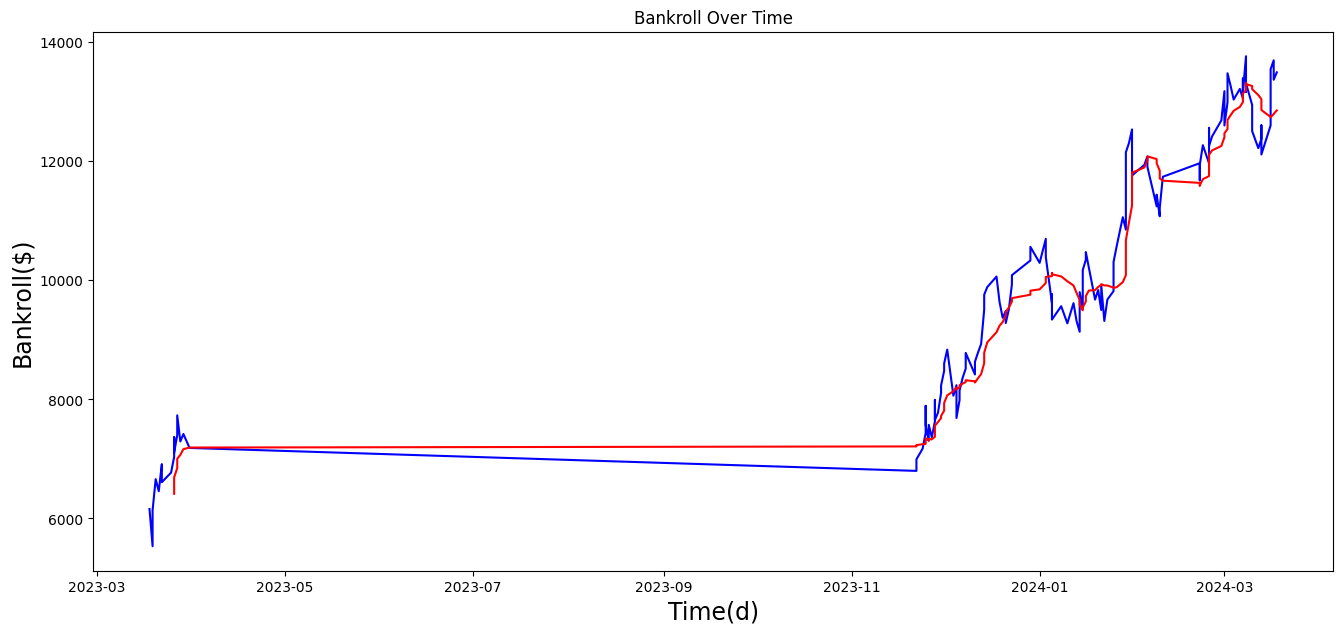



The position was held from 2023-03-18 to 2024-03-18, traded 143 times, and produced a return of 124.8845%.
The growth rate on each bet was 0.5683%.
The final balance is $13493.07.
The average of returns is 68.8837%.
The standard deviation of returns is 35.7749%.


The Sharpe Ratio of the strategy is 1.9255.


In [77]:
threshold_calmar = 1.1
spread_calmar = 0.06
bet_calmar = bet[bet['odds_diff'] > spread_calmar]
backtest(bet_calmar, 6000, 0.5, threshold_calmar)


In [78]:
bet_calmar

,Date,Teams_x,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual,odds_diff
19,2023-03-19,BRK,2.12,1.718750,0.581818,1,0,0.401250
22,2023-03-19,OKC,1.91,1.718750,0.581818,1,1,0.191250
33,2023-03-19,LAL,1.41,1.293103,0.773333,1,1,0.116897
36,2023-03-18,MEM,1.81,1.718750,0.581818,1,1,0.091250
41,2023-03-20,CHO,2.16,1.840000,0.543478,1,1,0.320000
...,...,...,...,...,...,...,...,...
1727,2024-03-17,MIL,1.69,1.611111,0.620690,1,1,0.078889
1741,2024-03-18,PHI,1.79,1.718750,0.581818,1,1,0.071250
1742,2024-03-17,BRK,2.05,1.840000,0.543478,1,0,0.210000
1746,2024-03-20,OKC,1.07,1.000000,1.000000,1,1,0.070000


## 3. Weights Construction <a id='3'></a>

- The intuition is that we want to use Markowitz' portfolio allocation, which is that we maximize the utility function

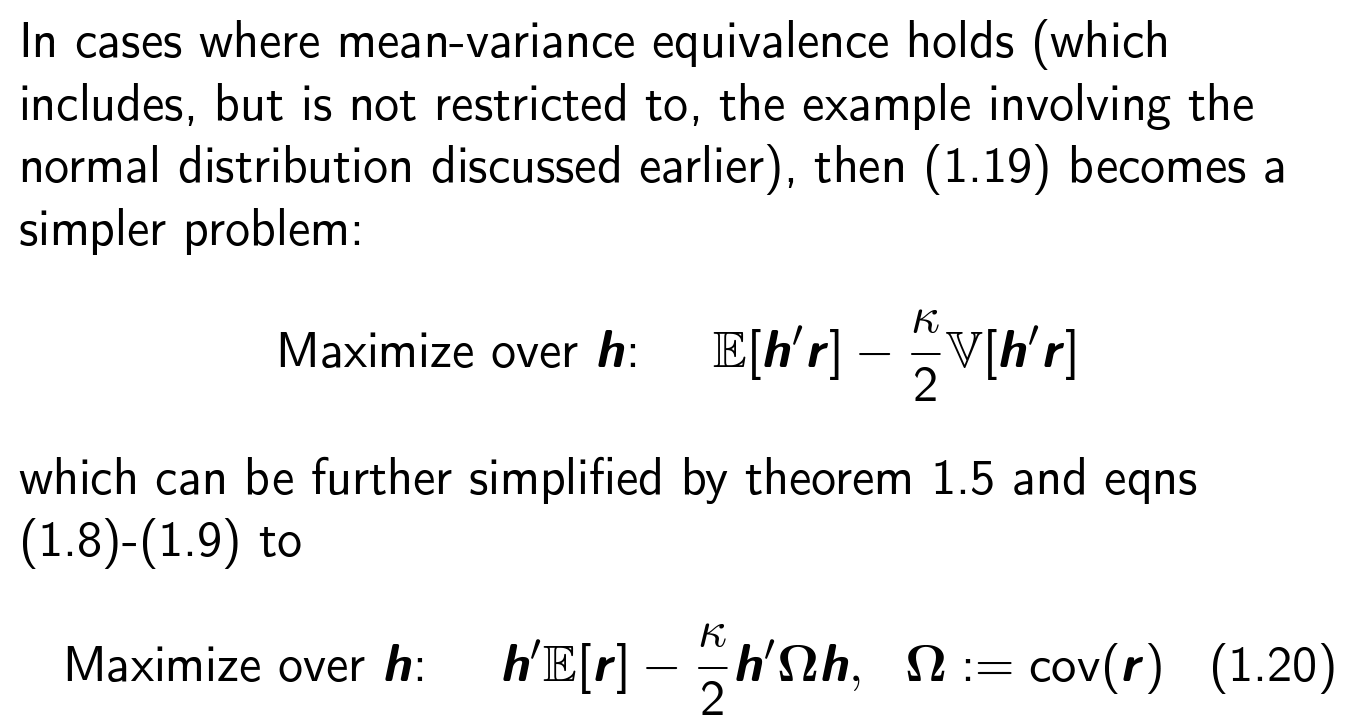

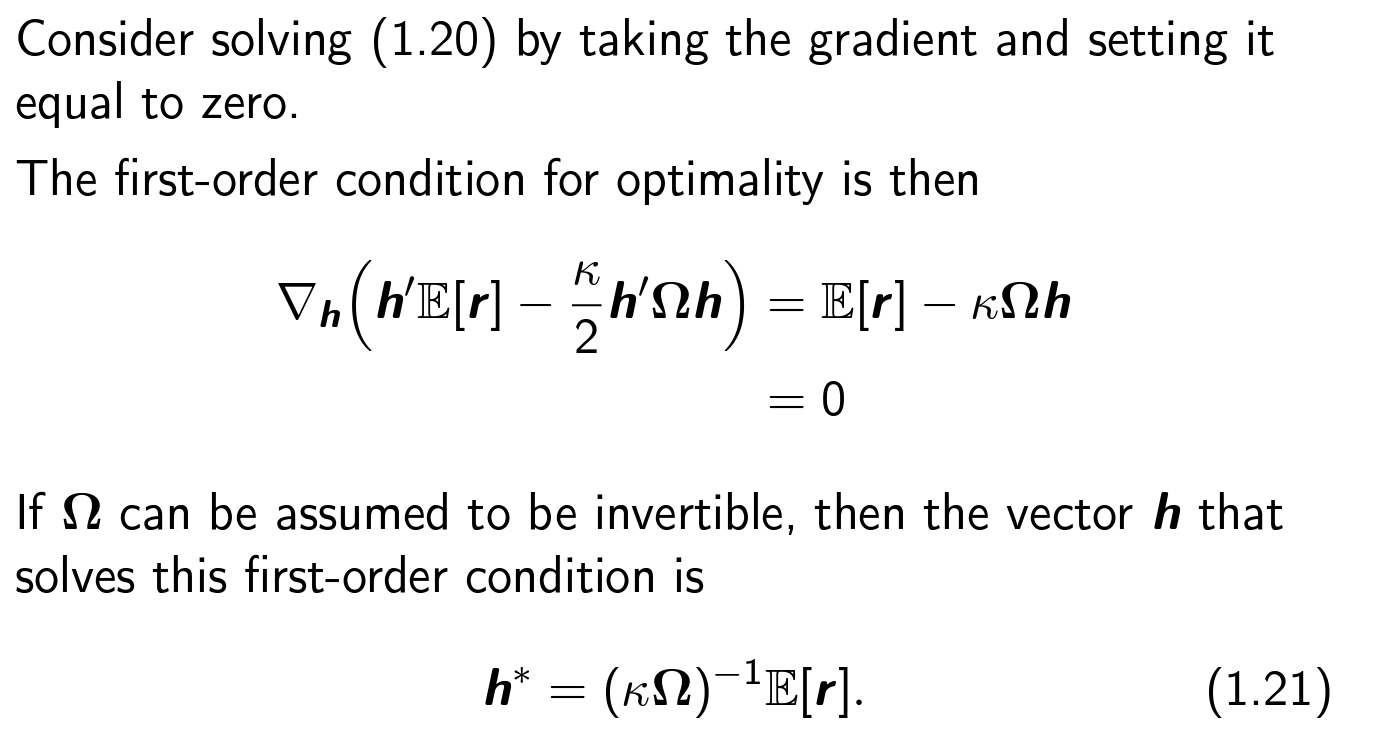

In [130]:
sharpe_p_and_l = p_and_l(bet_sharpe, 6000, 0.5, threshold_sharpe)
calmar_p_and_l = p_and_l(bet_calmar, 6000, 0.5, threshold_calmar)



The position was held for 2 months, traded 246 times, and produced a return of 117.7238%.
The growth rate on each bet was 0.3168%.
The final balance is $13063.43.
The average of returns is 74.2937%.
The standard deviation of returns is 32.0010%.


The Sharpe Ratio of the strategy is 2.3216.


The position was held for 2 months, traded 143 times, and produced a return of 124.8845%.
The growth rate on each bet was 0.5683%.
The final balance is $13493.07.
The average of returns is 68.8837%.
The standard deviation of returns is 35.7749%.


The Sharpe Ratio of the strategy is 1.9255.


In [166]:
sharpe_p_and_l.head()

,Date,Teams_x,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual,odds_diff,Kelly,p_and_l
0,2023-03-16,BRK,1.74,1.680000,0.595238,1,0,0.060000,0.024131,-144.787645
4,2023-03-18,MEM,1.81,1.718750,0.581818,1,1,0.091250,0.032772,159.272727
1,2023-03-19,BRK,2.12,1.718750,0.581818,1,0,0.401250,0.104221,-625.324675
2,2023-03-19,OKC,1.91,1.718750,0.581818,1,1,0.191250,0.061139,333.818182
3,2023-03-19,LAL,1.41,1.293103,0.773333,1,1,0.116897,0.110244,271.200000


In [139]:
pl_sharpe = sharpe_p_and_l.groupby("Date").sum()[['p_and_l']]
pl_calmar = calmar_p_and_l.groupby("Date").sum()[['p_and_l']]

initial = 6000
pl_sharpe['cumsum'] = pl_sharpe['p_and_l'].cumsum()
pl_sharpe['starting'] = (pl_sharpe['cumsum'] + initial).shift().fillna(initial)
pl_sharpe['return_pct'] = pl_sharpe['p_and_l']/pl_sharpe['starting']

pl_calmar['cumsum'] = pl_calmar['p_and_l'].cumsum()
pl_calmar['starting'] = (pl_calmar['cumsum'] + initial).shift().fillna(initial)
pl_calmar['return_pct'] = pl_calmar['p_and_l']/pl_calmar['starting']

total_p_and_l = pd.merge(pl_sharpe, pl_calmar, left_index=True, right_index=True, how='outer', suffixes=['_sharpe', '_calmar'])
total_p_and_l = total_p_and_l[['return_pct_sharpe', 'return_pct_calmar']].fillna(0)
total_p_and_l

,return_pct_sharpe,return_pct_calmar
Date,,
2023-03-16,-0.024131,0.000000
2023-03-18,0.027202,0.026545
2023-03-19,-0.003376,-0.003297
2023-03-20,0.093229,0.084988
2023-03-21,-0.031101,-0.030598
...,...,...
2024-03-14,0.010907,0.000000
2024-03-15,0.010038,0.000000
2024-03-16,0.122804,0.118449


In [160]:
### total_p_and_l is our return data
expected_returns = np.mean(total_p_and_l, axis=0)

# Calculate the covariance matrix of returns
cov_matrix = np.cov(total_p_and_l.T)  # .T to transpose for correct dimensionality

# Define the risk aversion coefficient (kappa) and it's subjective
kappa = 1

# Calculate the optimal holding vector
optimal_holding = np.linalg.inv(kappa * cov_matrix) @ expected_returns

print("Expected Returns:", expected_returns)
print("Covariance Matrix:\n", cov_matrix)
print("Optimal Holding Vector:", optimal_holding)

Expected Returns: return_pct_sharpe    0.00788
return_pct_calmar    0.00812
dtype: float64
Covariance Matrix:
 [[0.00144864 0.00133259]
 [0.00133259 0.00133823]]
Optimal Holding Vector: [-1.68929426  7.74957027]


#### Adding Constraints

In [167]:
# Number of assets (strategies)
n_assets = expected_returns.shape[0]
kappa = 0.8

# Optimization variables
h = cp.Variable(n_assets, nonneg=True)

# Objective function: Maximize utility (adjusted for risk aversion)
objective = cp.Maximize(h.T @ expected_returns.T - (kappa / 2) * cp.quad_form(h, cov_matrix))

# Constraints: h_i >= 0 for no short selling
# If insisting on h_i > 1 in some form, it needs careful definition. Here we use h_i >= 0.
constraints = [cp.sum(h) == 1]

# Define the problem and solve it
problem = cp.Problem(objective, constraints)
problem.solve()
optimal_holding = h.value

print("Optimal Holding Vector:", optimal_holding)


Optimal Holding Vector: [7.64005523e-23 1.00000000e+00]


In [159]:
print("Status:", problem.status)

Status: optimal
